# Question 1: Implementation of Adversarial Attacks Using FGSM

In [195]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## FGSM Implementation

In [196]:
def fgsm(model, loss_fn, images, labels, epsilon):
    images = images.clone().detach().to(next(model.parameters()).device)
    labels = labels.clone().detach().to(next(model.parameters()).device)
    images.requires_grad = True
    
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    
    grad_sign = images.grad.detach().sign()
    perturbed_images = images + epsilon * grad_sign
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
    return perturbed_images

## FGSM - Gaussain Implementation

In [197]:
def fgsm_gaussian(images, epsilon):
    images = images.clone().detach()
    noise = torch.randn_like(images) * epsilon
    perturbed_images = images + noise
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images


## Load MNIST Model

In [198]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1   = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

url = "https://huggingface.co/spaces/YesheyDema/pytorch-mnist-classifier/resolve/main/mnist_cnn.pth"
state_dict = torch.hub.load_state_dict_from_url(url, map_location=device)
model.load_state_dict(state_dict)


<All keys matched successfully>

In [199]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  
])

test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
loss_fn = nn.CrossEntropyLoss()
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)

def evaluate(model, loader, attack=None, epsilon=0.1, show_samples=True, num_images=3):
    model.eval()
    correct = 0
    total = 0

    sample_images, sample_labels = None, None
    sample_preds_clean, sample_preds_pert, sample_perturbed = None, None, None
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        if attack == "fgsm":
            perturbed = fgsm(model, loss_fn, images, labels, epsilon)
        elif attack == "gaussian":
            perturbed = fgsm_gaussian(images, epsilon)
        else:
            perturbed = images.clone()

        outputs = model(perturbed)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx == 1 and show_samples:
            sample_images = images[:num_images]
            sample_labels = labels[:num_images]
            sample_perturbed = perturbed[:num_images].detach()
            with torch.no_grad():
                sample_preds_clean = model(sample_images).argmax(dim=1)
                sample_preds_pert = model(sample_perturbed).argmax(dim=1)

    acc = 100 * correct / total

    if show_samples and sample_images is not None and (attack == "fgsm" or attack == "gaussian"):
        fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images*2))

        for i in range(num_images):
            axes[i,0].matshow(sample_images[i].detach().cpu().squeeze(), cmap="gray")
            axes[i,0].set_title(f"Clean: {sample_preds_clean[i].item()}")
            axes[i,0].axis("off")

            axes[i,1].matshow(sample_perturbed[i].detach().cpu().squeeze(), cmap="gray")
            axes[i,1].set_title(f"Perturbed Label: {sample_preds_pert[i].item()}")
            axes[i,1].axis("off")

        plt.tight_layout()
        plt.show()

    return acc


Clean vs Perturbed using FGSM


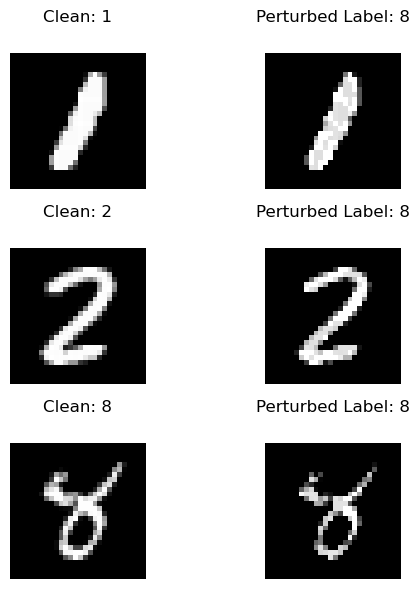

Clean vs Perturbed using Gaussian Noise


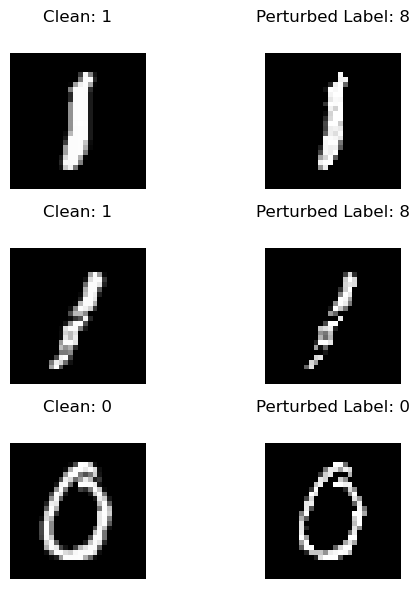

Accuracy on clean images: 97.79%
Accuracy under FGSM attack (ε=0.1): 42.46%
Accuracy under Gaussian noise (ε=0.1): 52.33%


In [200]:
eps = 0.1
acc_clean = evaluate(model, test_loader, attack=None, epsilon=eps)
print("Clean vs Perturbed using FGSM")
acc_fgsm = evaluate(model, test_loader, attack="fgsm", epsilon=eps)
print("Clean vs Perturbed using Gaussian Noise")
acc_gauss = evaluate(model, test_loader, attack="gaussian", epsilon=eps)

print(f"Accuracy on clean images: {acc_clean:.2f}%")
print(f"Accuracy under FGSM attack (ε={eps}): {acc_fgsm:.2f}%")
print(f"Accuracy under Gaussian noise (ε={eps}): {acc_gauss:.2f}%")

In [201]:
epsilons = [0.01, 0.1, 0.3, 0.5, 1.0]

fgsm_accs = []
gauss_accs = []

print("Running FGSM and Gaussian experiments...")
for eps in epsilons:
    acc_fgsm = evaluate(model, test_loader, attack="fgsm", epsilon=eps, show_samples=False)
    acc_gauss = evaluate(model, test_loader, attack="gaussian", epsilon=eps, show_samples=False)

    fgsm_accs.append(acc_fgsm)
    gauss_accs.append(acc_gauss)

    print(f"Epsilon {eps:.2f} | FGSM acc: {acc_fgsm:.2f}% | Gaussian acc: {acc_gauss:.2f}%")



Running FGSM and Gaussian experiments...
Epsilon 0.01 | FGSM acc: 52.53% | Gaussian acc: 53.68%
Epsilon 0.10 | FGSM acc: 42.46% | Gaussian acc: 52.40%
Epsilon 0.30 | FGSM acc: 19.93% | Gaussian acc: 44.46%
Epsilon 0.50 | FGSM acc: 10.23% | Gaussian acc: 32.23%
Epsilon 1.00 | FGSM acc: 9.25% | Gaussian acc: 14.20%


## Visualisations

In [ ]:
# FGSM plot
plt.figure(figsize=(6,4))
plt.plot(epsilons, fgsm_accs, marker='o', label="FGSM Attack")
plt.axhline(y=acc_clean, color="gray", linestyle="--", label="Clean baseline")
plt.title("FGSM Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig("fgsm_accuracy.png")
plt.close()

# Gaussian plot
plt.figure(figsize=(6,4))
plt.plot(epsilons, gauss_accs, marker='o', label="Gaussian Noise")
plt.axhline(y=acc_clean, color="gray", linestyle="--", label="Clean baseline")
plt.title("Gaussian Noise Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig("gaussian_accuracy.png")
plt.close()

# Combined plot
plt.figure(figsize=(6,4))
plt.plot(epsilons, fgsm_accs, marker='o', label="FGSM Attack")
plt.plot(epsilons, gauss_accs, marker='s', label="Gaussian Noise")
plt.axhline(y=acc_clean, color="gray", linestyle="--", label="Clean baseline")
plt.title("Accuracy vs Epsilon (FGSM vs Gaussian)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig("fgsm_vs_gaussian.png")
plt.close()
